In [1]:
import pandas as pd
import warnings
import rpy2
warnings.filterwarnings('ignore')

In [2]:
%load_ext rpy2.ipython

# Prueba Completa

In [3]:
import plotly.graph_objects as go

def plot_(title, *series):
    # Crear una figura
    fig = go.Figure()

    # Agregar cada serie de datos al gráfico
    for x_variable, y_variable, label in series:
        fig.add_trace(go.Scatter(
            x=x_variable,
            y=y_variable,
            mode='lines',
            name=label,
            line=dict(width=2)
        ))

    # Actualizar el tipo de eje x a 'date'
    fig.update_xaxes(type='date')

    # Ajustar el título para que esté centrado
    fig.update_layout(title_text=title, title_x=0.5)

    # Personalizar el selector de rango de fechas
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label="1d",
                         step="day",
                         stepmode="backward"),
                    dict(count=7,
                         label="1w",
                         step="day",
                         stepmode="backward"),
                    dict(count=1,
                         label="1m",
                         step="month",
                         stepmode="backward"),
                    dict(count=3,
                         label="3m",
                         step="month",
                         stepmode="backward"),
                    dict(count=6,
                         label="6m",
                         step="month",
                         stepmode="backward"),
                    dict(count=1,
                         label="1y",
                         step="year",
                         stepmode="backward"),
                    dict(count=2,
                         label="2y",
                         step="year",
                         stepmode="backward"),
                    dict(count=3,
                         label="3y",
                         step="year",
                         stepmode="backward"),
                    dict(count=5,
                         label="5y",
                         step="year",
                         stepmode="backward"),
                    dict(count=10,
                         label="10y",
                         step="year",
                         stepmode="backward"),
                    dict(count=20,
                         label="20y",
                         step="year",
                         stepmode="backward"),
                    dict(count=30,
                         label="30y",
                         step="year",
                         stepmode="backward"),
                    dict(count=50,
                         label="50y",
                         step="year",
                         stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        ),
        yaxis=dict(
            autorange=True,
            type="linear"
        )
    )

    # Personalizar los títulos de los ejes
    fig.update_layout(
        xaxis_title="Tiempo",
        yaxis_title="Indice de producción"
    )

    # Personalizar la leyenda
    fig.update_layout(
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=-.35
        )
    )

    # Mostrar el gráfico
    fig.show()


Rolling Forecast (ARIMA (1, 0, 13)): 100%|██████████| 13/13 [00:34<00:00,  2.65s/it]


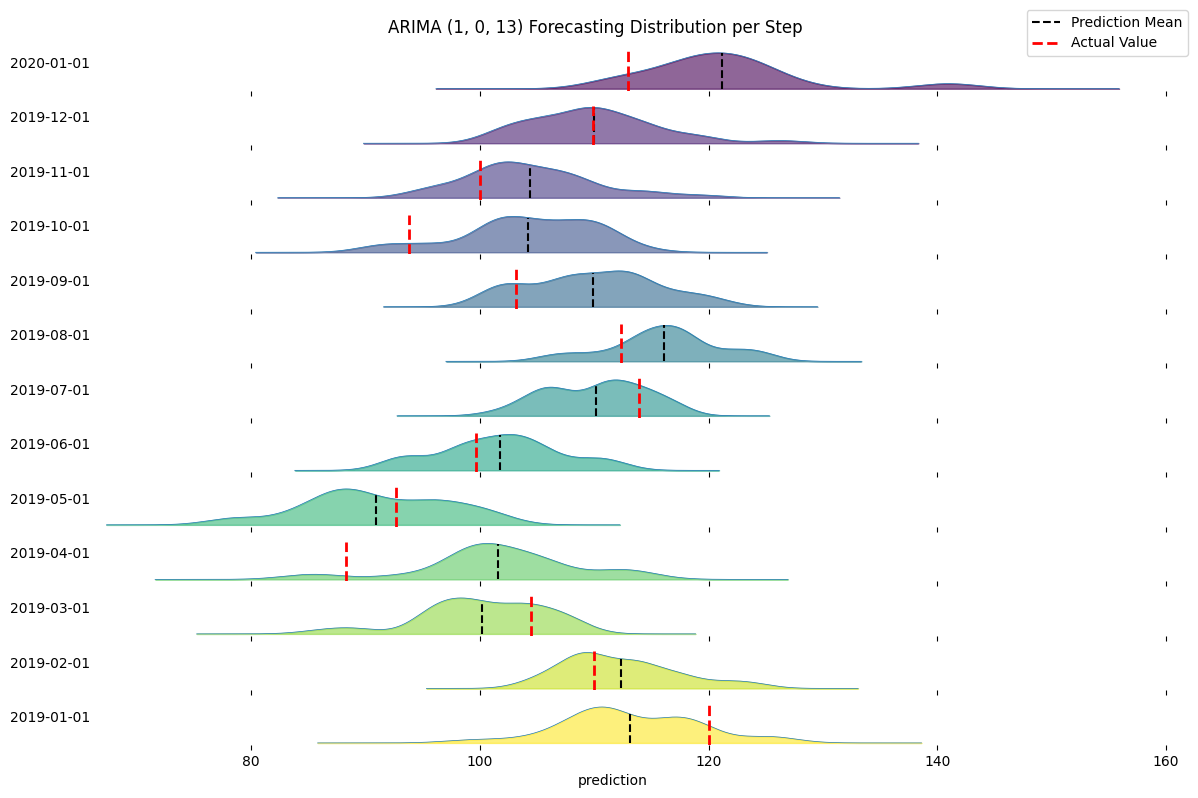

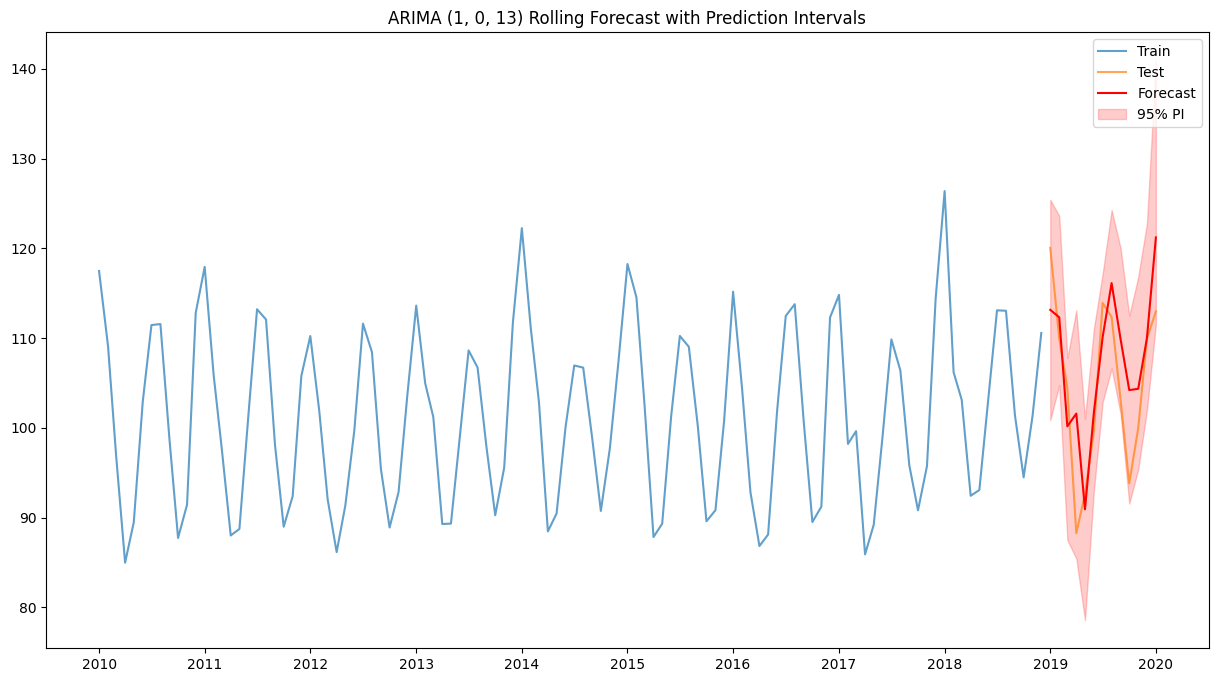

CRPS Score for ARIMA (1, 0, 13): 4.719940239642966


Rolling Forecast (ARIMA (2, 0, 2)): 100%|██████████| 13/13 [00:03<00:00,  3.74it/s]


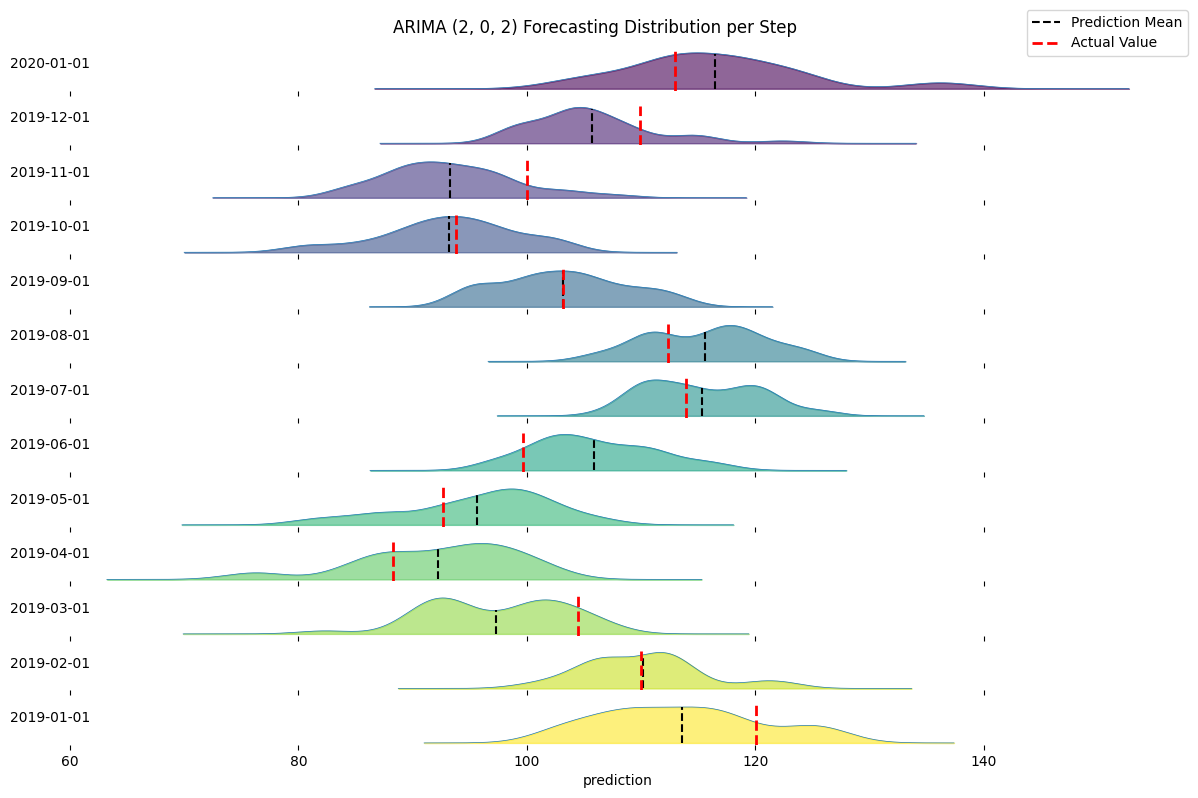

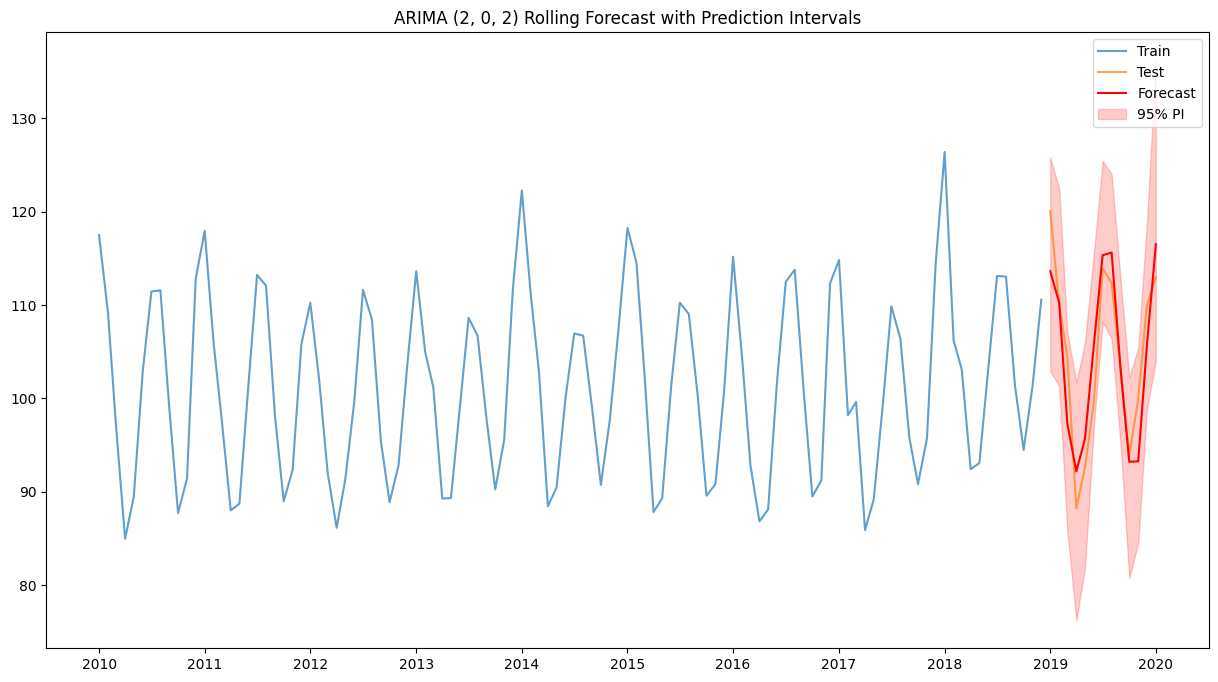

CRPS Score for ARIMA (2, 0, 2): 4.681002496127946


Rolling Forecast (ARIMA (1, 0, 1)): 100%|██████████| 13/13 [00:01<00:00,  8.19it/s]


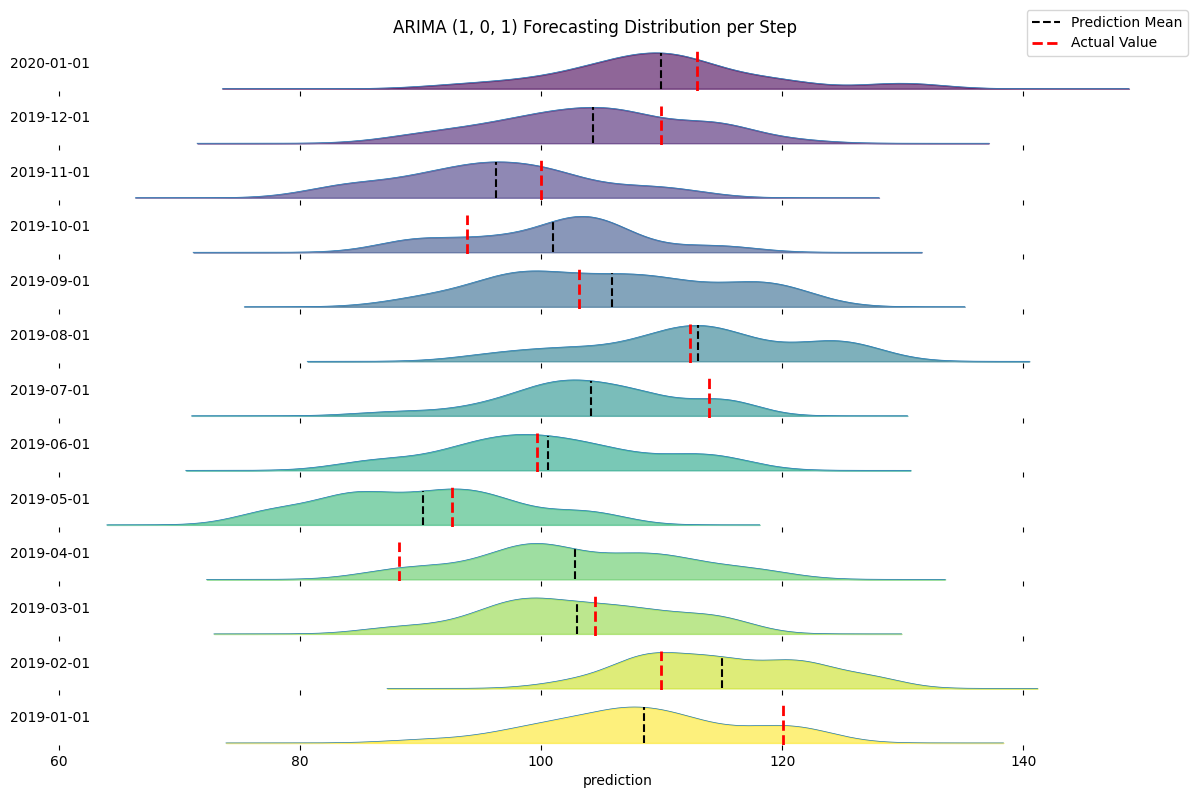

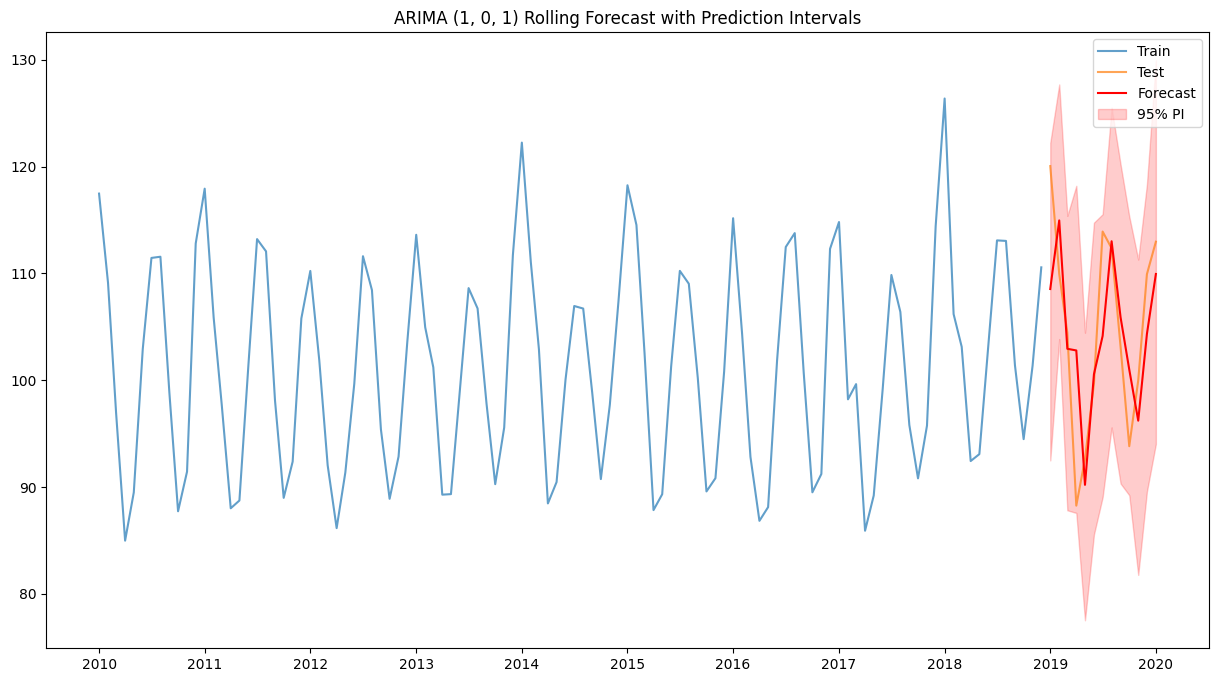

CRPS Score for ARIMA (1, 0, 1): 4.522865809800364


,Model,Order,CRPS
0,ARIMA,"(1, 0, 1)",4.522866
1,ARIMA,"(2, 0, 2)",4.681002
2,ARIMA,"(1, 0, 13)",4.719940


In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from typing import Optional, Any
from tqdm import tqdm
import scoringrules as sr  # Make sure you have this library installed

warnings.filterwarnings('ignore')

def fit_arima_model(train_data, order):
    model = ARIMA(train_data, order=order, freq='MS')  # Order is now a parameter
    return model.fit()

def predict_bootstrapping(model, train_data, steps=1, n_boot=500, random_state=123):
    predictions = model.forecast(steps=steps)
    residuals = model.resid
    
    boot_predictions = np.full((steps, n_boot), np.nan)
    rng = np.random.default_rng(seed=random_state)
    
    for i in range(n_boot):
        sample_residuals = rng.choice(residuals, size=steps, replace=True)
        boot_predictions[:, i] = predictions + sample_residuals
    
    return pd.DataFrame(boot_predictions, columns=[f"pred_boot_{i}" for i in range(n_boot)],
                        index=pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1), periods=steps, freq='MS'))

def rolling_forecast_with_bootstrapping(train, test, window_size=24, n_boot=500, order=(1, 0, 13)):
    all_bootstrap_predictions = []
    
    for i in tqdm(range(len(test)), desc=f"Rolling Forecast (ARIMA {order})"):
        train_window = pd.concat([train, test.iloc[:i]])
        model = fit_arima_model(train_window.iloc[-window_size:], order=order)
        bootstrap_predictions = predict_bootstrapping(model, train_window.iloc[-window_size:], steps=1, n_boot=n_boot)
        all_bootstrap_predictions.append(bootstrap_predictions)
    
    return pd.concat(all_bootstrap_predictions)

def plot_prediction_distribution(bootstrapping_predictions: pd.DataFrame,
                                 model_order: tuple,
                                 test_data: pd.Series,
                                 bw_method: Optional[Any] = None,
                                 **fig_kw) -> plt.Figure:
    index = bootstrapping_predictions.index.astype(str).to_list()[::-1]
    palette = plt.cm.viridis(np.linspace(0, 1, len(index)))
    
    # Remove test_data from fig_kw if it's there
    fig_kw.pop('test_data', None)
    
    fig, axs = plt.subplots(len(index), 1, sharex=True, **fig_kw)
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])

    # Create empty lists to store legend handles and labels
    legend_handles = []
    legend_labels = []

    for i, step in enumerate(index):
        plot = (
            bootstrapping_predictions.loc[step, :]
            .plot.kde(ax=axs[i], bw_method=bw_method, lw=0.5)
        )
        x = plot.get_children()[0]._x
        y = plot.get_children()[0]._y
        axs[i].fill_between(x, y, color=palette[i], alpha=0.6)
        
        prediction_mean = bootstrapping_predictions.loc[step, :].mean()
        idx = np.abs(x - prediction_mean).argmin()
        mean_line = axs[i].vlines(x[idx], ymin=0, ymax=y[idx], linestyle="dashed", color='black')
        
        # Plot the real test value in red
        real_value = test_data.loc[step]
        actual_line = axs[i].axvline(x=real_value, color='red', linestyle='--', linewidth=2)
        
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        axs[i].set_yticklabels([])
        axs[i].set_yticks([])
        axs[i].set_ylabel(step, rotation='horizontal')
        axs[i].set_xlabel('prediction')
        
        # Add legend handles and labels only once
        if i == 0:
            legend_handles.extend([mean_line, actual_line])
            legend_labels.extend(['Prediction Mean', 'Actual Value'])

    fig.subplots_adjust(hspace=-0)
    model_title = f"ARIMA {model_order} Forecasting Distribution per Step"
    fig.suptitle(model_title)
    
    # Add a single legend for the entire figure
    fig.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=fig.transFigure)

    return fig

def plot_forecast_with_pi(train, test, forecasts, lower_pi, upper_pi, model_order):
    plt.figure(figsize=(15, 8))
    plt.plot(train.index, train, label='Train', alpha=0.7)
    plt.plot(test.index, test, label='Test', alpha=0.7)
    plt.plot(forecasts.index, forecasts, label='Forecast', color='red')
    plt.fill_between(forecasts.index, lower_pi, upper_pi, color='red', alpha=0.2, label='95% PI')
    plt.title(f'ARIMA {model_order} Rolling Forecast with Prediction Intervals')
    plt.legend()
    plt.savefig(f"forecast_ARIMA_{model_order}.png")
    plt.show()

def calculate_crps(observations, forecast_ensemble):
    crps_values = []
    for i in range(len(observations)):
        obs = np.array([observations[i]])
        fct = forecast_ensemble.iloc[i].values
        crps = sr.crps_ensemble(obs, fct)
        crps_values.append(crps)
    return np.mean(crps_values)

# Load and prepare the data
data = pd.read_csv('../../../data/IPG2211A2N_1.csv')
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data['IPG2211A2N'] = pd.to_numeric(data['IPG2211A2N'], errors='coerce')
data.dropna(inplace=True)

train = data[data.index.year < 2019]
test = data[data.index.year >= 2019]

# ARIMA orders to test
orders = [(1, 0, 13), (2, 0, 2), (1, 0, 1)]
results = []

for order in orders:
    # Perform rolling forecast with bootstrapping
    bootstrap_predictions = rolling_forecast_with_bootstrapping(train['IPG2211A2N'], test['IPG2211A2N'], window_size=24, n_boot=100, order=order)
    
    # Plot the prediction distributions
    fig = plot_prediction_distribution(bootstrap_predictions, model_order=order, test_data=test['IPG2211A2N'], figsize=(12, 8))
    plt.tight_layout()
    fig.savefig(f"distribution_ARIMA_{order}.png")
    plt.show()
    
    # Calculate forecasts and prediction intervals
    forecasts = bootstrap_predictions.mean(axis=1)
    lower_pi = bootstrap_predictions.quantile(0.025, axis=1)
    upper_pi = bootstrap_predictions.quantile(0.975, axis=1)
    
    # Plot the forecast with prediction intervals
    plot_forecast_with_pi(train['IPG2211A2N'], test['IPG2211A2N'], forecasts, lower_pi, upper_pi, model_order=order)
    
    # Calculate CRPS for the bootstrap predictions
    observed_values = test['IPG2211A2N'].values
    forecast_ensemble = bootstrap_predictions.T
    crps_score = calculate_crps(observed_values, forecast_ensemble)
    print(f"CRPS Score for ARIMA {order}: {crps_score}")
    
    # Append the results to the final table
    results.append(('ARIMA', f"{order}", crps_score))

# Create a table with the results
results_df = pd.DataFrame(results, columns=['Model', 'Order', 'CRPS'])

# Order the table by CRPS descending
results_df = results_df.sort_values(by='CRPS').reset_index(drop=True)

# Display the results table
results_df


Performing grid search for best SARIMA orders...
Best SARIMA order: (0, 1, 2)
Best seasonal order: (0, 1, 1, 12)


Rolling Forecast (SARIMA (0, 1, 2)(0, 1, 1, 12)): 100%|██████████| 13/13 [00:00<00:00, 17.09it/s]


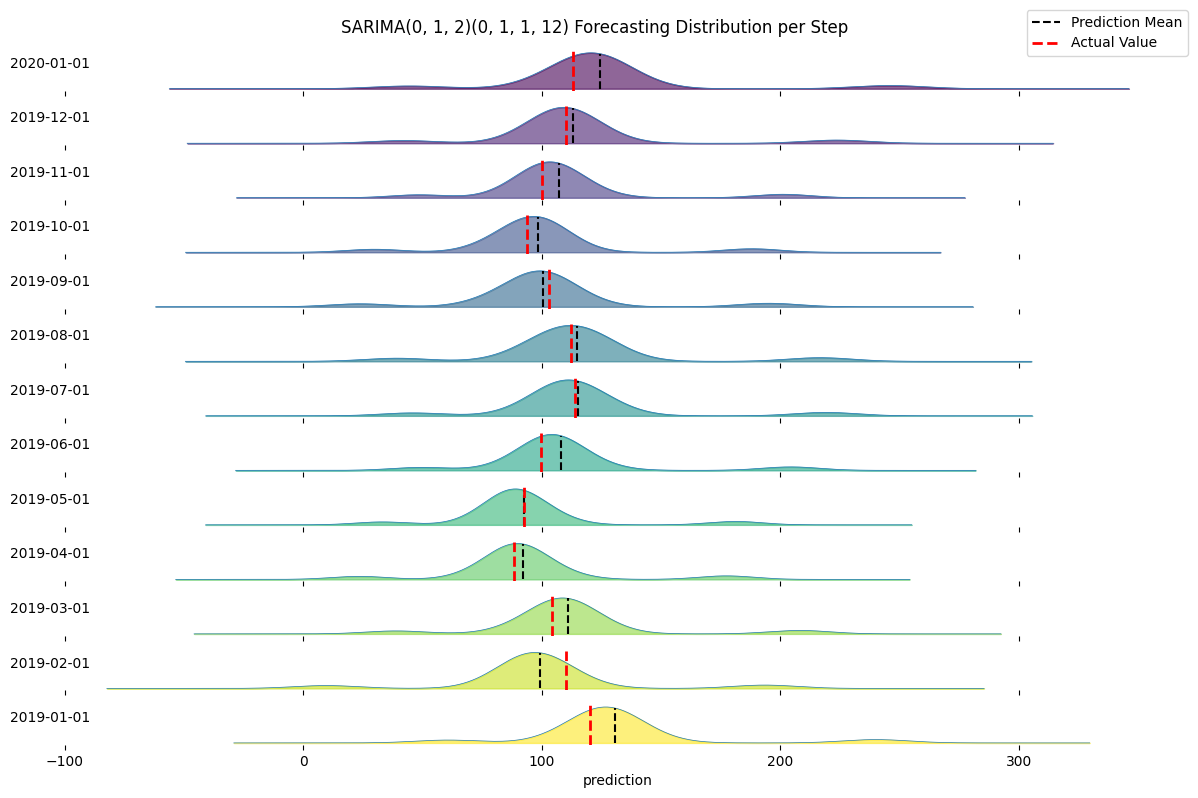

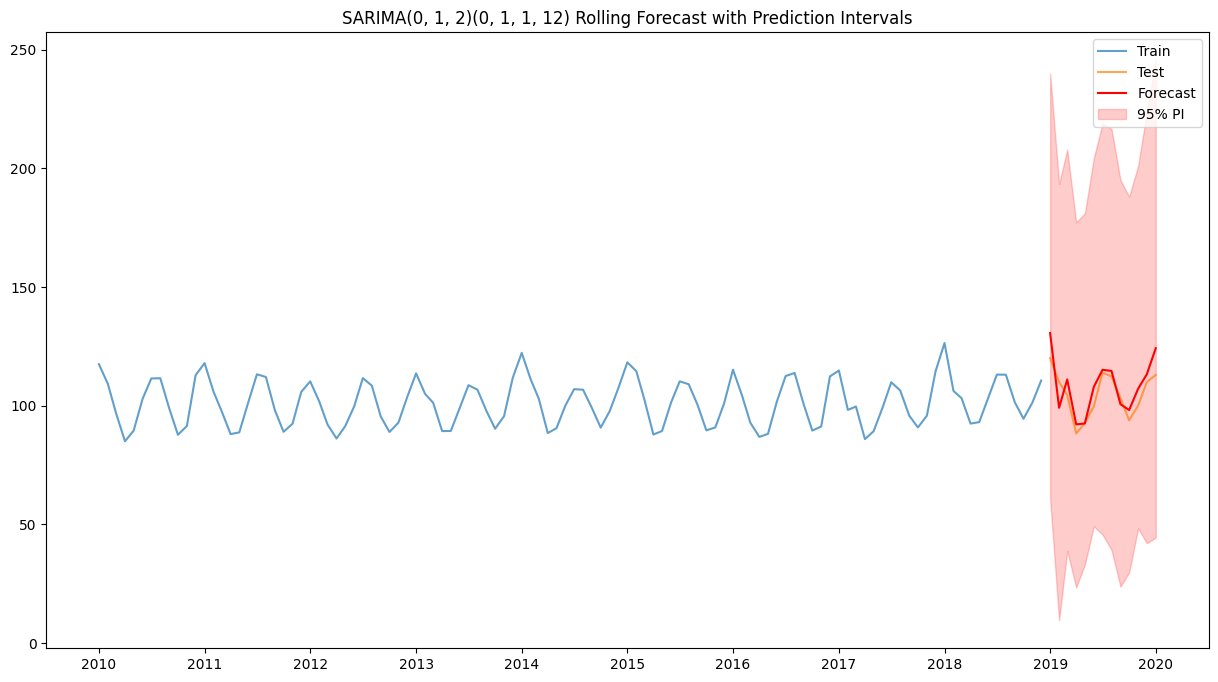

CRPS Score for SARIMA ((0, 1, 2), (0, 1, 1, 12)): 10.353278320458914


Rolling Forecast (SARIMA (1, 1, 2)(0, 1, 1, 12)): 100%|██████████| 13/13 [00:00<00:00, 15.97it/s]


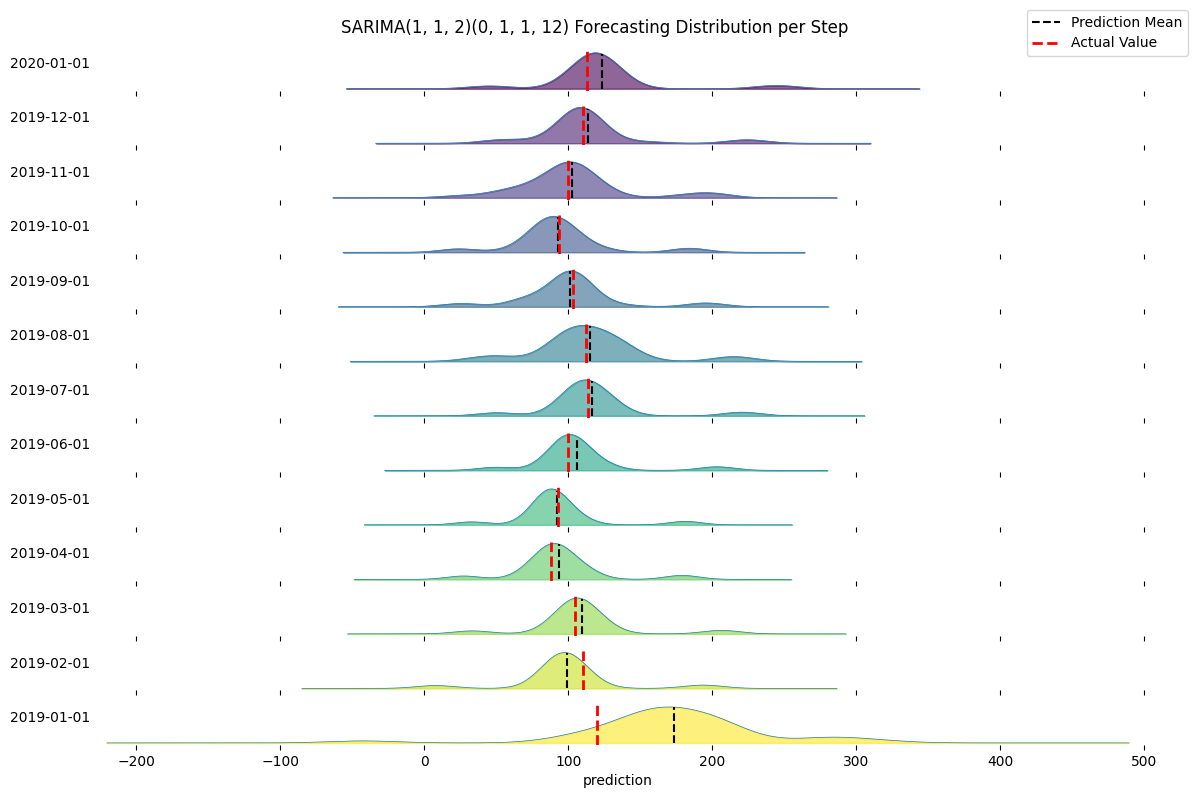

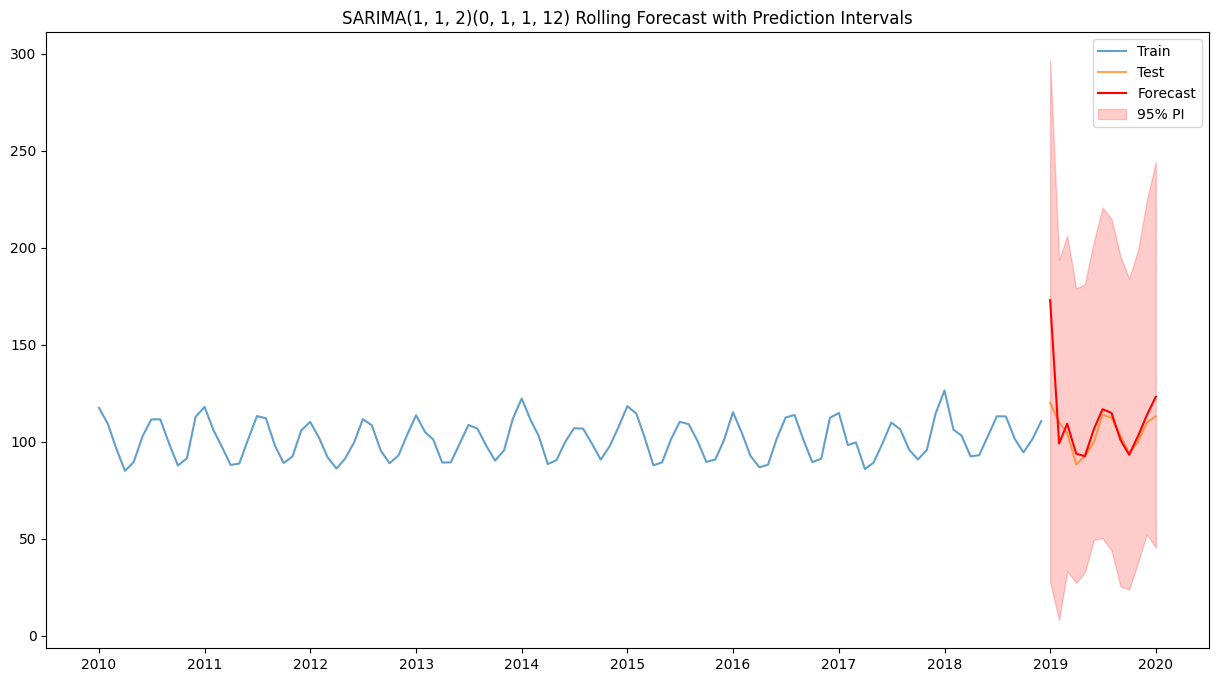

CRPS Score for SARIMA ((1, 1, 2), (0, 1, 1, 12)): 11.42929512937968


Rolling Forecast (SARIMA (0, 1, 2)(0, 1, 2, 12)): 100%|██████████| 13/13 [00:02<00:00,  4.96it/s]


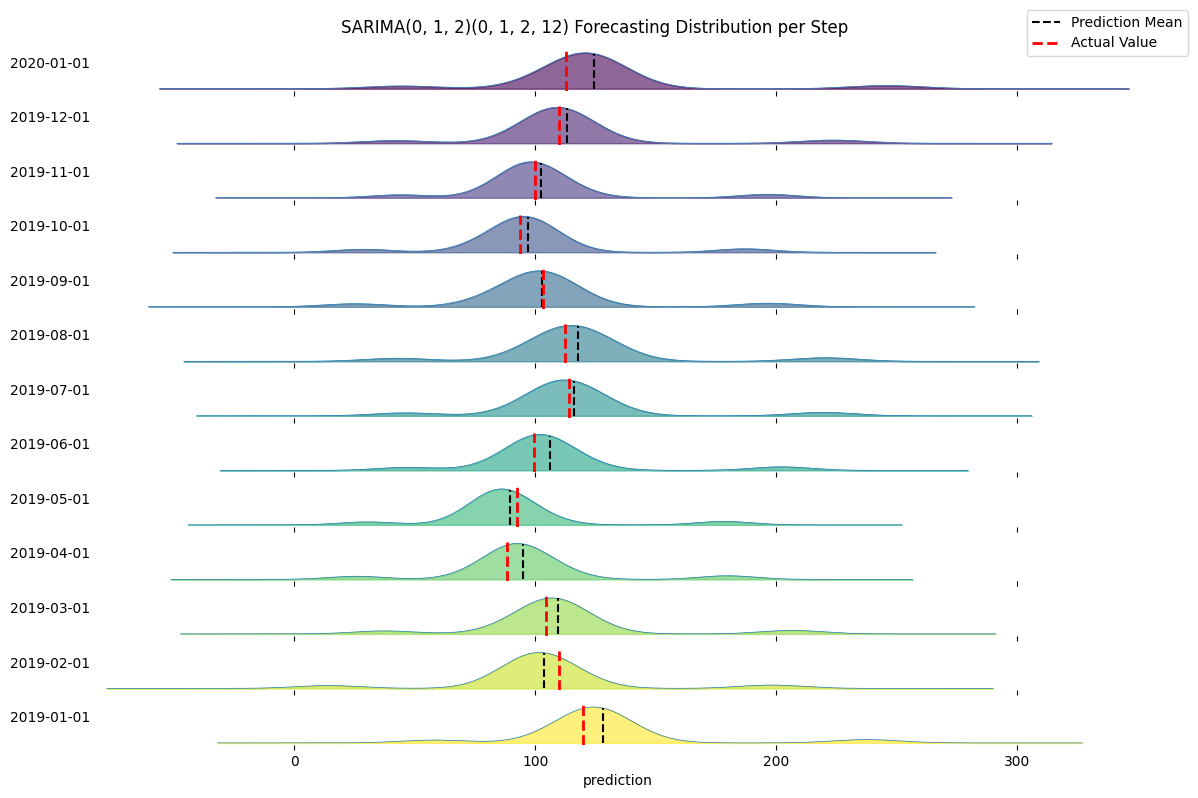

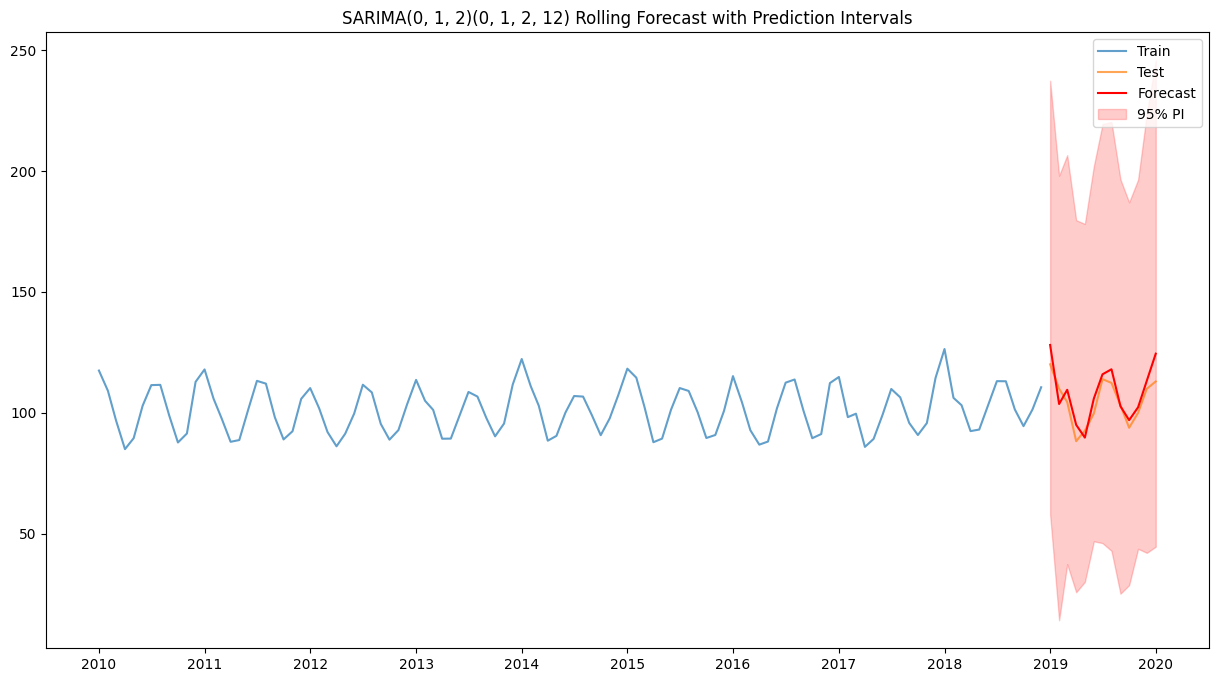

CRPS Score for SARIMA ((0, 1, 2), (0, 1, 2, 12)): 10.496085746492144
SARIMA orders and their CRPS scores:


,Model,Order,CRPS
0,SARIMA,"((0, 1, 2), (0, 1, 1, 12))",10.353278
1,SARIMA,"((0, 1, 2), (0, 1, 2, 12))",10.496086
2,SARIMA,"((1, 1, 2), (0, 1, 1, 12))",11.429295


In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from typing import Optional, Any
from tqdm import tqdm
import scoringrules as sr
from itertools import product
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings('ignore')

def fit_sarima_model(train_data, order, seasonal_order):
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    return model.fit(disp=False)

def predict_bootstrapping(model, train_data, steps=1, n_boot=500, random_state=123):
    predictions = model.forecast(steps=steps)
    residuals = model.resid
    
    boot_predictions = np.full((steps, n_boot), np.nan)
    rng = np.random.default_rng(seed=random_state)
    
    for i in range(n_boot):
        sample_residuals = rng.choice(residuals, size=steps, replace=True)
        boot_predictions[:, i] = predictions + sample_residuals
    
    return pd.DataFrame(boot_predictions, columns=[f"pred_boot_{i}" for i in range(n_boot)],
                        index=pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1), periods=steps, freq='MS'))

def rolling_forecast_with_bootstrapping(train, test, window_size=24, n_boot=500, order=(1,1,1), seasonal_order=(1,1,1,12)):
    all_bootstrap_predictions = []
    
    for i in tqdm(range(len(test)), desc=f"Rolling Forecast (SARIMA {order}{seasonal_order})"):
        train_window = pd.concat([train, test.iloc[:i]])
        model = fit_sarima_model(train_window.iloc[-window_size:], order=order, seasonal_order=seasonal_order)
        bootstrap_predictions = predict_bootstrapping(model, train_window.iloc[-window_size:], steps=1, n_boot=n_boot)
        all_bootstrap_predictions.append(bootstrap_predictions)
    
    return pd.concat(all_bootstrap_predictions)

def plot_prediction_distribution(bootstrapping_predictions: pd.DataFrame,
                                 model_order: tuple,
                                 test_data: pd.Series,
                                 bw_method: Optional[Any] = None,
                                 **fig_kw) -> plt.Figure:
    index = bootstrapping_predictions.index.astype(str).to_list()[::-1]
    palette = plt.cm.viridis(np.linspace(0, 1, len(index)))
    
    fig_kw.pop('test_data', None)
    
    fig, axs = plt.subplots(len(index), 1, sharex=True, **fig_kw)
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])

    legend_handles = []
    legend_labels = []

    for i, step in enumerate(index):
        plot = (
            bootstrapping_predictions.loc[step, :]
            .plot.kde(ax=axs[i], bw_method=bw_method, lw=0.5)
        )
        x = plot.get_children()[0]._x
        y = plot.get_children()[0]._y
        axs[i].fill_between(x, y, color=palette[i], alpha=0.6)
        
        prediction_mean = bootstrapping_predictions.loc[step, :].mean()
        idx = np.abs(x - prediction_mean).argmin()
        mean_line = axs[i].vlines(x[idx], ymin=0, ymax=y[idx], linestyle="dashed", color='black')
        
        real_value = test_data.loc[step]
        actual_line = axs[i].axvline(x=real_value, color='red', linestyle='--', linewidth=2)
        
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        axs[i].set_yticklabels([])
        axs[i].set_yticks([])
        axs[i].set_ylabel(step, rotation='horizontal')
        axs[i].set_xlabel('prediction')
        
        if i == 0:
            legend_handles.extend([mean_line, actual_line])
            legend_labels.extend(['Prediction Mean', 'Actual Value'])

    fig.subplots_adjust(hspace=-0)
    model_title = f"SARIMA{model_order[0]}{model_order[1]} Forecasting Distribution per Step"
    fig.suptitle(model_title)
    
    fig.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=fig.transFigure)

    return fig

def plot_forecast_with_pi(train, test, forecasts, lower_pi, upper_pi, model_order):
    plt.figure(figsize=(15, 8))
    plt.plot(train.index, train, label='Train', alpha=0.7)
    plt.plot(test.index, test, label='Test', alpha=0.7)
    plt.plot(forecasts.index, forecasts, label='Forecast', color='red')
    plt.fill_between(forecasts.index, lower_pi, upper_pi, color='red', alpha=0.2, label='95% PI')
    plt.title(f'SARIMA{model_order[0]}{model_order[1]} Rolling Forecast with Prediction Intervals')
    plt.legend()
    plt.savefig(f"forecast_SARIMA_{model_order}.png")
    plt.show()

def calculate_crps(observations, forecast_ensemble):
    crps_values = []
    for i in range(len(observations)):
        obs = np.array([observations[i]])
        fct = forecast_ensemble.iloc[i].values
        crps = sr.crps_ensemble(obs, fct)
        crps_values.append(crps)
    return np.mean(crps_values)

def sarima_grid_search(data, p_range, d_range, q_range, P_range, D_range, Q_range, s=12):
    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None

    pdq = list(product(p_range, d_range, q_range))
    seasonal_pdq = list(product(P_range, D_range, Q_range, [s]))

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(data, order=param, seasonal_order=param_seasonal, 
                                enforce_stationarity=False, enforce_invertibility=False)
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = param
                    best_seasonal_order = param_seasonal
            except:
                continue

    return best_order, best_seasonal_order

# Load and prepare the data
data = pd.read_csv('../../../data/IPG2211A2N_1.csv')
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data['IPG2211A2N'] = pd.to_numeric(data['IPG2211A2N'], errors='coerce')
data.dropna(inplace=True)

train = data[data.index.year < 2019]
test = data[data.index.year >= 2019]

# Perform grid search to find the best SARIMA orders
print("Performing grid search for best SARIMA orders...")
best_order, best_seasonal_order = sarima_grid_search(
    train['IPG2211A2N'],
    p_range=range(0, 3),
    d_range=range(0, 2),
    q_range=range(0, 3),
    P_range=range(0, 2),
    D_range=range(0, 2),
    Q_range=range(0, 2),
    s=12
)

print(f"Best SARIMA order: {best_order}")
print(f"Best seasonal order: {best_seasonal_order}")

# Generate two more orders by slightly modifying the best order
orders = [
    (best_order, best_seasonal_order),
    ((best_order[0]+1, best_order[1], best_order[2]), best_seasonal_order),
    (best_order, (best_seasonal_order[0], best_seasonal_order[1], best_seasonal_order[2]+1, best_seasonal_order[3]))
]

results = []

for order in orders:
    # Perform rolling forecast with bootstrapping
    bootstrap_predictions = rolling_forecast_with_bootstrapping(train['IPG2211A2N'], test['IPG2211A2N'], 
                                                                window_size=24, n_boot=100, 
                                                                order=order[0], seasonal_order=order[1])
    
    # Plot the prediction distributions
    fig = plot_prediction_distribution(bootstrap_predictions, model_order=order, test_data=test['IPG2211A2N'], figsize=(12, 8))
    plt.tight_layout()
    fig.savefig(f"distribution_SARIMA_{order}.png")
    plt.show()
    
    # Calculate forecasts and prediction intervals
    forecasts = bootstrap_predictions.mean(axis=1)
    lower_pi = bootstrap_predictions.quantile(0.025, axis=1)
    upper_pi = bootstrap_predictions.quantile(0.975, axis=1)
    
    # Plot the forecast with prediction intervals
    plot_forecast_with_pi(train['IPG2211A2N'], test['IPG2211A2N'], forecasts, lower_pi, upper_pi, model_order=order)
    
    # Calculate CRPS for the bootstrap predictions
    observed_values = test['IPG2211A2N'].values
    forecast_ensemble = bootstrap_predictions.T
    crps_score = calculate_crps(observed_values, forecast_ensemble)
    print(f"CRPS Score for SARIMA {order}: {crps_score}")
    
    # Append the results to the final table
    results.append(('SARIMA', f"{order}", crps_score))

# Create a table with the results
results_df = pd.DataFrame(results, columns=['Model', 'Order', 'CRPS'])

# Order the table by CRPS ascending (lower is better)
results_df = results_df.sort_values(by='CRPS').reset_index(drop=True)

# Display the results table
print("SARIMA orders and their CRPS scores:")
results_df